In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf
import matplotlib.pyplot as plt

# EDA

### Data exploration

In [2]:
nyc_df = pd.read_csv('nyc_data.csv', index_col=0, parse_dates=True)
nyc_df.head()

,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
Date,,,,,,
2015-01-01,720.000885,0,0,0,3.68,41.305
2015-01-02,581.276773,0,0,0,4.73,131.574
2015-01-03,754.117039,0,0,0,7.23,162.700
2015-01-04,622.252774,0,0,0,10.96,160.281
2015-01-05,785.373319,0,0,0,6.92,51.077


In [3]:
nyc_df = nyc_df.rename(columns={'Demand':'y'})
nyc_df.head(1)

,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
Date,,,,,,
2015-01-01,720.000885,0,0,0,3.68,41.305


In [4]:
nyc_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
y,2192.0,756.059227,152.143070,425.77532,641.161123,736.94763,855.645886,1384.908525
Easter,2192.0,0.002737,0.052259,0.00000,0.000000,0.00000,0.000000,1.000000
Thanksgiving,2192.0,0.002737,0.052259,0.00000,0.000000,0.00000,0.000000,1.000000
Christmas,2192.0,0.002737,0.052259,0.00000,0.000000,0.00000,0.000000,1.000000
Temperature,2192.0,15.012655,8.772751,-8.85000,7.767500,14.89500,23.230000,30.900000
Marketing,2192.0,126.675890,58.274047,24.58900,78.303500,122.76450,169.395250,299.860000


### Seasonal decomposition

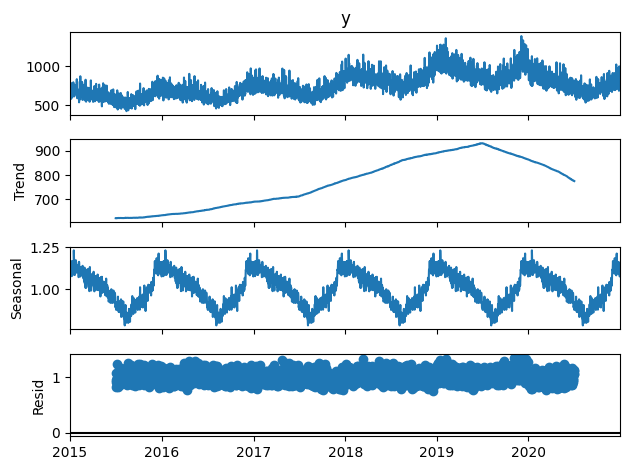

In [5]:
decomposition = seasonal_decompose(x=nyc_df.y, model="multiplicative", period=365)
decomposition.plot();

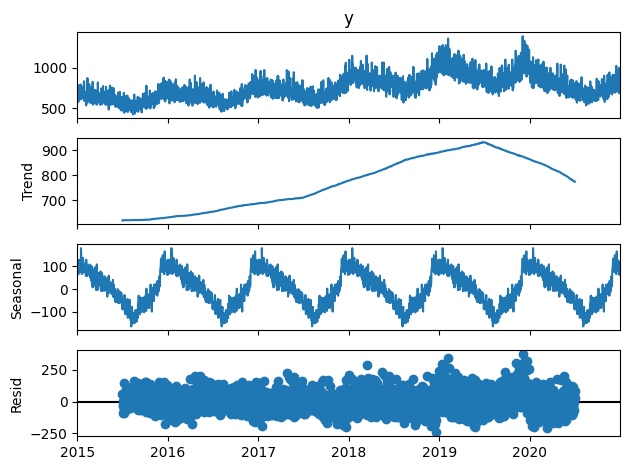

In [6]:
decomposition = seasonal_decompose(x=nyc_df.y, model="additive", period=365)
decomposition.plot();

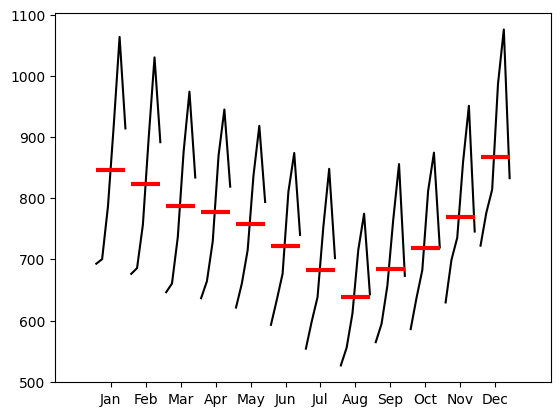

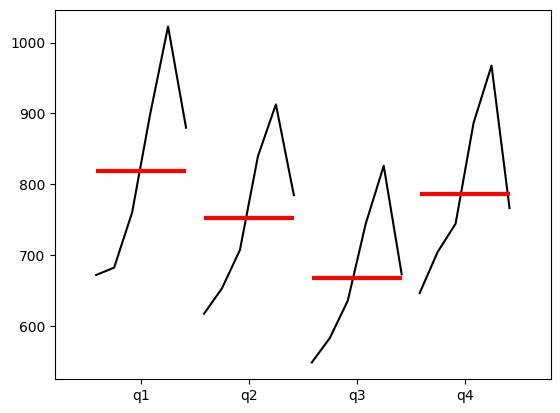

In [7]:
month_plot(nyc_df.y.resample('MS').mean());
quarter_plot(nyc_df.y.resample('QS').mean());

### Data visualization

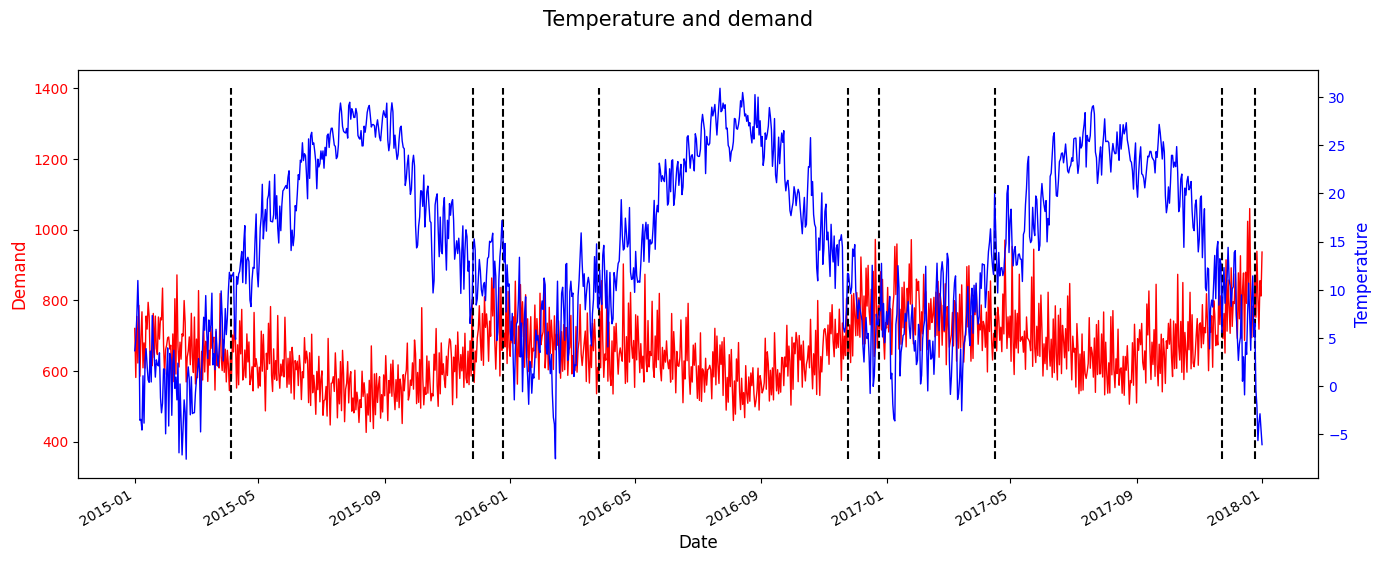

In [8]:
df_plot = nyc_df.loc['2015-01-01':'2018-01-01']

fig, ax1 = plt.subplots(figsize=(16, 6))
ax2 = ax1.twinx()
ax1.plot(df_plot.index, df_plot.y, color = 'red', lw=1)
ax2.plot(df_plot.index, df_plot.Temperature, color = 'blue', lw=1)
fig.suptitle("Temperature and demand", fontsize=15)
fig.autofmt_xdate()
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Demand', fontsize=12, color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax2.set_ylabel('Temperature', fontsize=12, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

events = df_plot[(df_plot.Easter == 1) | (df_plot.Thanksgiving == 1) | (df_plot.Christmas == 1)].index
ax1.vlines(events, ymin=350, ymax=1400, color='black', ls = '--');

### Correlation

In [9]:
nyc_df[['y', 'Temperature', 'Marketing']].corr()

,y,Temperature,Marketing
y,1.000000,-0.400261,0.275139
Temperature,-0.400261,1.000000,-0.185626
Marketing,0.275139,-0.185626,1.000000


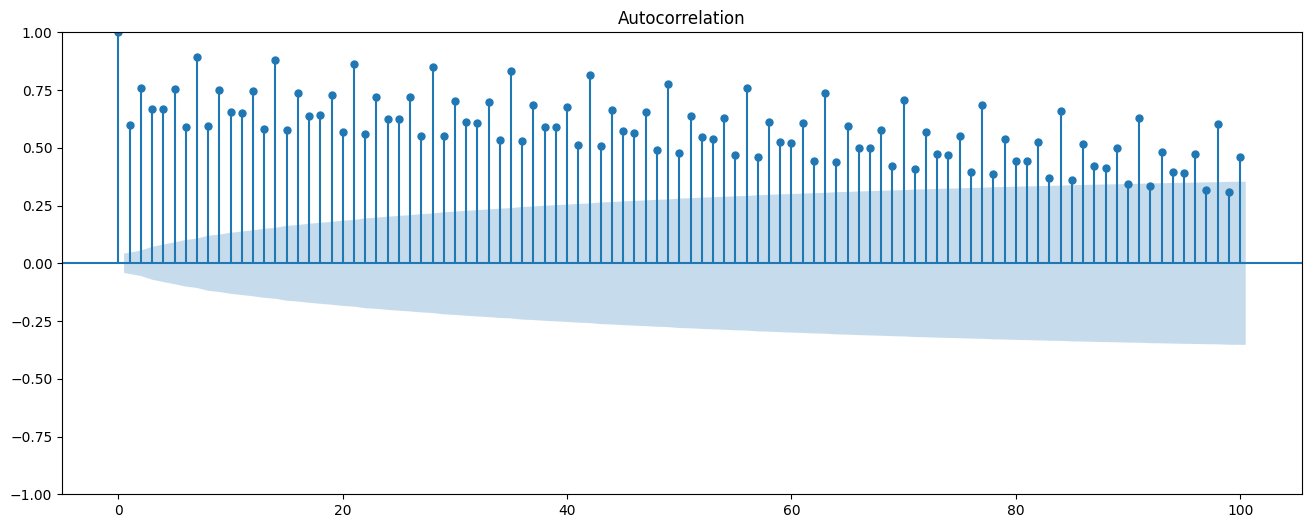

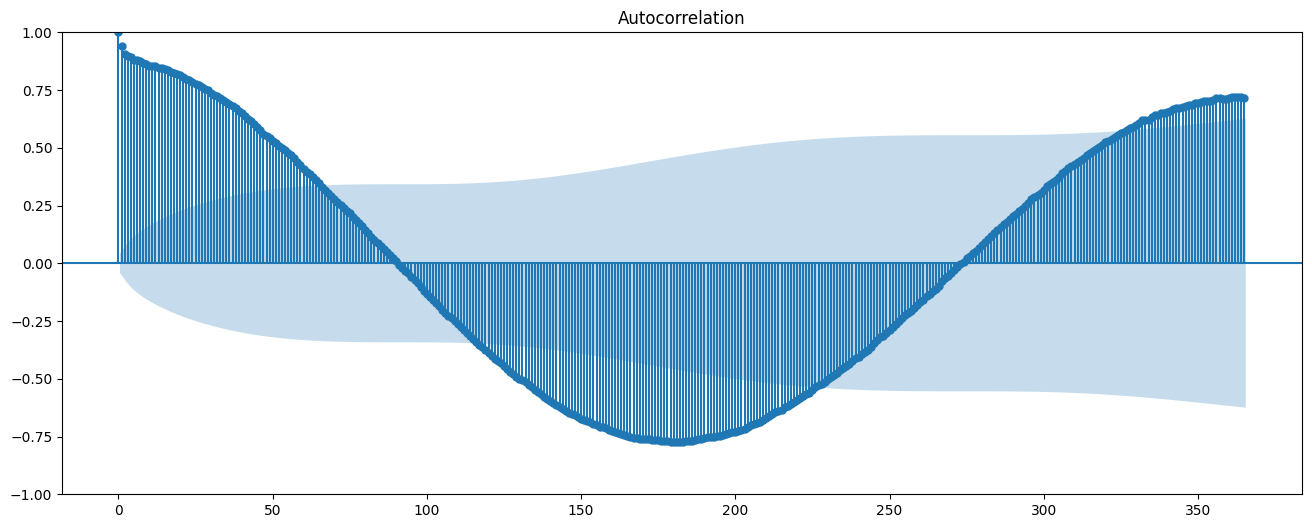

In [10]:
plt.rcParams["figure.figsize"] = (16, 6)
plot_acf(nyc_df.y, lags=100)
plot_acf(nyc_df.Temperature, lags=365);

# Using Prophet

In [11]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.model_selection import ParameterGrid

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [12]:
df = pd.read_csv('nyc_data.csv')
df = df.rename(columns={'Demand':'y'})
df.Date = pd.to_datetime(df.Date, format="%m/%d/%Y")
df.head()

,Date,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,2015-01-01,720.000885,0,0,0,3.68,41.305
1,2015-01-02,581.276773,0,0,0,4.73,131.574
2,2015-01-03,754.117039,0,0,0,7.23,162.700
3,2015-01-04,622.252774,0,0,0,10.96,160.281
4,2015-01-05,785.373319,0,0,0,6.92,51.077


### Holidays

In [13]:
dates = df[df['Easter']==1].Date
easter = pd.DataFrame({'holiday':'easter',
                       'Date':dates,
                       'lower_window':-5,
                       'upper_window':2})
dates = df[df['Thanksgiving']==1].Date
thanksgiving = pd.DataFrame({'holiday':'Thanksgiving',
                             'Date':dates,
                             'lower_window':-3,
                             'upper_window':5})
dates = df[df['Christmas']==1].Date
christmas = pd.DataFrame({'holiday':'Christmas',
                          'Date':dates,
                          'lower_window':-7,
                          'upper_window':7})

In [14]:
holidays = pd.concat([easter, thanksgiving, christmas])
holidays = holidays.rename(columns={'Date':'ds'})
holidays

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2
1928,easter,2020-04-12,-5,2
329,Thanksgiving,2015-11-26,-3,5
693,Thanksgiving,2016-11-24,-3,5
1057,Thanksgiving,2017-11-23,-3,5
1421,Thanksgiving,2018-11-22,-3,5


In [15]:
df_finals = df.drop(columns=['Easter', 'Christmas', 'Thanksgiving'])
df_finals = df_finals.rename(columns={'Date':'ds'})
df_finals.head(3)

,ds,y,Temperature,Marketing
0,2015-01-01,720.000885,3.68,41.305
1,2015-01-02,581.276773,4.73,131.574
2,2015-01-03,754.117039,7.23,162.700


### Prophet Model

In [16]:
# Create the model
model = Prophet(holidays=holidays,
                seasonality_mode="multiplicative",
                seasonality_prior_scale=10,
                holidays_prior_scale=10,
                changepoint_prior_scale=0.05)
model.add_regressor("Temperature")
model.add_regressor("Marketing")
model.fit(df_finals)

18:34:19 - cmdstanpy - INFO - Chain [1] start processing
18:34:19 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
# Cross validation
df_cv = cross_validation(model=model,
                         horizon="31 days",
                         period="16 days",
                         initial="2012 days",
                         parallel="processes")
df_cv.head()

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
18:34:21 - cmdstanpy - INFO - Chain [1] start processing
18:34:21 - cmdstanpy - INFO - Chain [1] start processing
18:34:21 - cmdstanpy - INFO - Chain [1] start processing
18:34:21 - cmdstanpy - INFO - Chain [1] start processing
18:34:21 - cmdstanpy - INFO - Chain [1] start processing
18:34:21 - cmdstanpy - INFO - Chain [1] start processing
18:34:21 - cmdstanpy - INFO - Chain [1] start processing
18:34:21 - cmdstanpy - INFO - Chain [1] start processing
18:34:21 - cmdstanpy - INFO - Chain [1] done processing
18:34:21 - cmdstanpy - I

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-07-10,607.499140,542.452080,680.732122,571.069531,2020-07-09
1,2020-07-11,722.634921,656.408707,790.005076,677.106981,2020-07-09
2,2020-07-12,637.583947,575.014626,704.001905,619.572774,2020-07-09
3,2020-07-13,769.739945,702.823853,835.955298,808.932621,2020-07-09
4,2020-07-14,637.140205,568.470572,699.475110,661.791644,2020-07-09


In [18]:
performance_metrics(df_cv).head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,4 days,2835.305633,53.247588,43.891082,0.059522,0.062052,0.060637,0.800000
1,5 days,2805.058737,52.962805,44.459988,0.062175,0.064329,0.062985,0.800000
2,6 days,3506.742867,59.217758,50.437771,0.069745,0.064329,0.071177,0.735484
3,7 days,2793.504189,52.853611,42.672894,0.060136,0.058434,0.061192,0.767742
4,8 days,2746.225410,52.404441,40.219295,0.055561,0.056580,0.057067,0.767742


In [19]:
rmse = performance_metrics(df_cv)["rmse"].mean()
mae = performance_metrics(df_cv)["mae"].mean()
mape = performance_metrics(df_cv)["mape"].mean()
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MAE: {mae:.3f}")

RMSE: 54.076
MAPE: 5.86%
MAE: 43.215


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


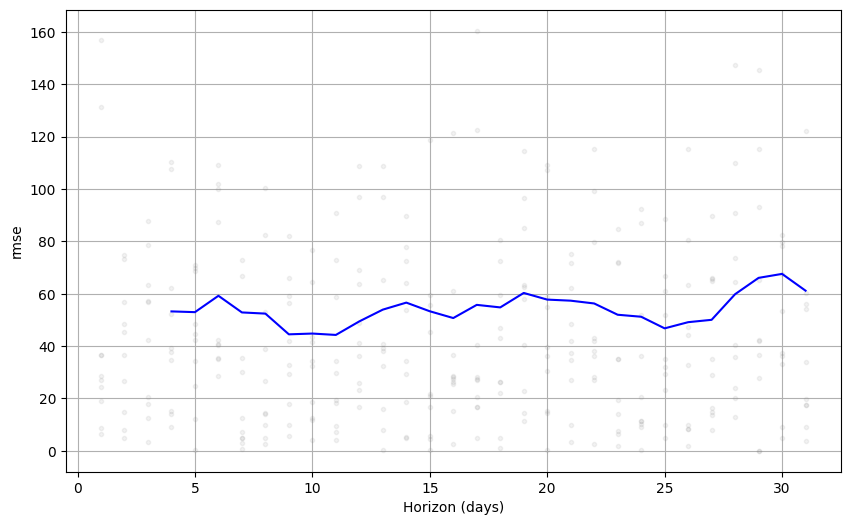

In [20]:
plot_cross_validation_metric(df_cv, metric="rmse");

### Parameter Tuning

In [21]:
param_grid = {"seasonality_mode" : ["additive", "multiplicative"],
              "seasonality_prior_scale" : [5, 10, 20],
              "holidays_prior_scale" : [5, 10, 20],
              "changepoint_prior_scale" : [0.01, 0.05, 0.1]}
grid = ParameterGrid(param_grid)

In [22]:
rmse = []

for params in grid:
    model = Prophet(holidays=holidays,
                    seasonality_mode=params["seasonality_mode"],
                    seasonality_prior_scale=params["seasonality_prior_scale"],
                    holidays_prior_scale=params["holidays_prior_scale"],
                    changepoint_prior_scale=params["changepoint_prior_scale"])
    model.add_regressor("Temperature")
    model.add_regressor("Marketing")
    model.fit(df_finals)

    df_cv = cross_validation(model=model,
                             horizon="31 days",
                             period="16 days",
                             initial="2012 days",
                             parallel="processes")
    error = round(performance_metrics(df_cv)["rmse"].mean(), 1)
    rmse.append(error)

18:34:22 - cmdstanpy - INFO - Chain [1] start processing
18:34:22 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
18:34:24 - cmdstanpy - INFO - Chain [1] start processing
18:34:24 - cmdstanpy - INFO - Chain [1] start processing
18:34:24 - cmdstanpy - INFO - Chain [1] start processing
18:34:24 - cmdstanpy - INFO - Chain [1] start processing
18:34:24 - cmdstanpy - INFO - Chain [1] start processing
18:34:24 - cmdstanpy - INFO - Chain [1] start processing
18:34:24 - cmdstanpy - INFO - Chain [1] start processing
18:34:24 - cmdstanpy - I

In [23]:
tuning_result = pd.DataFrame(grid)
tuning_result['rmse'] = rmse
tuning_result.head(3)

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
0,0.01,5,additive,5,48.7
1,0.01,5,additive,10,48.4
2,0.01,5,additive,20,48.8


In [24]:
tuning_result[tuning_result.rmse == tuning_result.rmse.min()].transpose()

,1
changepoint_prior_scale,0.01
holidays_prior_scale,5
seasonality_mode,additive
seasonality_prior_scale,10
rmse,48.4


# Future predictions

In [38]:
df = pd.read_csv("nyc_data.csv")
df_future = pd.read_csv("future.csv")

In [39]:
df = pd.concat([df, df_future])
df.rename(columns={"Date":"ds", "Demand":"y"})
df.Date = pd.to_datetime(df.Date, format="%m/%d/%Y")
df = df.reset_index(drop=True)
df = df.drop(columns=["Easter", "Thanksgiving", "Christmas"])
df.tail(2)

,Date,Demand,Temperature,Marketing
2221,2021-01-30,NaN,1.11,152.752
2222,2021-01-31,NaN,4.44,158.620
